In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, to_date

In [2]:
# Create or get Spark session
spark = SparkSession.builder.appName("Bronze_to_Silver_Transactions").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 08:41:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setLogLevel("ERROR")

In [4]:
bronze_path = "/app/datamart/bronze/transactions" 

In [5]:
# Load all Bronze parquet files
df_bronze = spark.read.parquet(bronze_path)
print("Bronze schema:")
df_bronze.printSchema()

Bronze schema:
root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- source_file: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [7]:
# Check count and percentage of payment_method_id (overall)

from pyspark.sql.functions import col, round

# Compute total row count first
total_rows = df_bronze.count()

# Group, count, calculate percentage, and show all
df_bronze.groupBy("payment_method_id") \
    .count() \
    .withColumn("percentage", round(col("count") / total_rows * 100, 2)) \
    .orderBy(col("count").desc()) \
    .show(df_bronze.select("payment_method_id").distinct().count(), truncate=False)

[Stage 13:==================================================>     (25 + 3) / 28]

+-----------------+--------+----------+
|payment_method_id|count   |percentage|
+-----------------+--------+----------+
|41               |12219879|53.19     |
|40               |2308019 |10.05     |
|38               |1819465 |7.92      |
|39               |1603775 |6.98      |
|37               |1048103 |4.56      |
|36               |945953  |4.12      |
|34               |762638  |3.32      |
|35               |551141  |2.4       |
|33               |427879  |1.86      |
|31               |263939  |1.15      |
|32               |247463  |1.08      |
|30               |182135  |0.79      |
|29               |138822  |0.6       |
|28               |99185   |0.43      |
|27               |64599   |0.28      |
|23               |45105   |0.2       |
|20               |34929   |0.15      |
|19               |34209   |0.15      |
|22               |29693   |0.13      |
|21               |24729   |0.11      |
|18               |16886   |0.07      |
|24               |16200   |0.07      |


In [12]:
from pyspark.sql.functions import col, round, count, sum as _sum

# Step 1: group by year and payment_method_id
df_year_method = (
    df_bronze.groupBy("year", "payment_method_id")
    .agg(count("*").alias("count"))
)

# Step 2: compute total per year
df_year_totals = (
    df_year_method.groupBy("year")
    .agg(_sum("count").alias("year_total"))
)

# Step 3: join + calculate percentage
df_result = (
    df_year_method.join(df_year_totals, on="year", how="left")
    .withColumn("percentage", round(col("count") / col("year_total") * 100, 2))
    .orderBy(col("year").asc(), col("count").desc())
)

# Step 4: split by year
df_2015 = df_result.filter(col("year") == 2015)
df_2016 = df_result.filter(col("year") == 2016)
df_2017 = df_result.filter(col("year") == 2017)

# Step 5: show each table (no row limit)
df_2015.show(df_2015.count(), truncate=False)
df_2016.show(df_2016.count(), truncate=False)
df_2017.show(df_2017.count(), truncate=False)

+----+-----------------+-------+----------+----------+
|year|payment_method_id|count  |year_total|percentage|
+----+-----------------+-------+----------+----------+
|2015|41               |4155100|8588546   |48.38     |
|2015|40               |1083984|8588546   |12.62     |
|2015|39               |851349 |8588546   |9.91      |
|2015|38               |776110 |8588546   |9.04      |
|2015|37               |459110 |8588546   |5.35      |
|2015|34               |287751 |8588546   |3.35      |
|2015|35               |190036 |8588546   |2.21      |
|2015|36               |189735 |8588546   |2.21      |
|2015|33               |173656 |8588546   |2.02      |
|2015|31               |98023  |8588546   |1.14      |
|2015|32               |95805  |8588546   |1.12      |
|2015|28               |38825  |8588546   |0.45      |
|2015|30               |31857  |8588546   |0.37      |
|2015|27               |28734  |8588546   |0.33      |
|2015|24               |16200  |8588546   |0.19      |
|2015|22  

In [13]:
# Check count and percentage of payment_plan_days (overall)

from pyspark.sql.functions import col, round

# Compute total row count first
total_rows = df_bronze.count()

# Group, count, calculate percentage, and show all
df_bronze.groupBy("payment_plan_days") \
    .count() \
    .withColumn("percentage", round(col("count") / total_rows * 100, 2)) \
    .orderBy(col("count").desc()) \
    .show(df_bronze.select("payment_plan_days").distinct().count(), truncate=False)


+-----------------+--------+----------+
|payment_plan_days|count   |percentage|
+-----------------+--------+----------+
|30               |20170971|87.79     |
|0                |872339  |3.8       |
|31               |766610  |3.34      |
|7                |589790  |2.57      |
|410              |162236  |0.71      |
|195              |138802  |0.6       |
|180              |76172   |0.33      |
|10               |38632   |0.17      |
|90               |31440   |0.14      |
|100              |28252   |0.12      |
|395              |20543   |0.09      |
|120              |13619   |0.06      |
|60               |10301   |0.04      |
|360              |10144   |0.04      |
|200              |8946    |0.04      |
|14               |6447    |0.03      |
|1                |5435    |0.02      |
|240              |4528    |0.02      |
|365              |4150    |0.02      |
|400              |3673    |0.02      |
|415              |3299    |0.01      |
|450              |3033    |0.01      |


In [15]:
from pyspark.sql.functions import col, round, count, sum as _sum

# Step 1: group by year and payment_plan_days
df_year_plan = (
    df_bronze.groupBy("year", "payment_plan_days")
    .agg(count("*").alias("count"))
)

# Step 2: compute total per year
df_year_totals = (
    df_year_plan.groupBy("year")
    .agg(_sum("count").alias("year_total"))
)

# Step 3: join + calculate percentage
df_result_plan = (
    df_year_plan.join(df_year_totals, on="year", how="left")
    .withColumn("percentage", round(col("count") / col("year_total") * 100, 2))
    .orderBy(col("year").asc(), col("count").desc())
)

# Step 4: split by year
df_2015_plan = df_result_plan.filter(col("year") == 2015)
df_2016_plan = df_result_plan.filter(col("year") == 2016)
df_2017_plan = df_result_plan.filter(col("year") == 2017)

# Step 5: show each table (no row limit)
df_2015_plan.show(df_2015_plan.count(), truncate=False)
df_2016_plan.show(df_2016_plan.count(), truncate=False)
df_2017_plan.show(df_2017_plan.count(), truncate=False)

+----+-----------------+-------+----------+----------+
|year|payment_plan_days|count  |year_total|percentage|
+----+-----------------+-------+----------+----------+
|2015|30               |6525791|8588546   |75.98     |
|2015|0                |872335 |8588546   |10.16     |
|2015|31               |766610 |8588546   |8.93      |
|2015|7                |198001 |8588546   |2.31      |
|2015|410              |69039  |8588546   |0.8       |
|2015|195              |63697  |8588546   |0.74      |
|2015|180              |26314  |8588546   |0.31      |
|2015|10               |24906  |8588546   |0.29      |
|2015|395              |9227   |8588546   |0.11      |
|2015|100              |7988   |8588546   |0.09      |
|2015|14               |5945   |8588546   |0.07      |
|2015|360              |3692   |8588546   |0.04      |
|2015|1                |2884   |8588546   |0.03      |
|2015|60               |2817   |8588546   |0.03      |
|2015|200              |2354   |8588546   |0.03      |
|2015|90  

In [22]:
# Check count and percentage of plan_list_price (overall)

from pyspark.sql.functions import col, round

# Compute total row count first
total_rows = df_bronze.count()

# Group, count, calculate percentage, and show all
df_bronze.groupBy("plan_list_price") \
    .count() \
    .withColumn("percentage", round(col("count") / total_rows * 100, 2)) \
    .orderBy(col("count").desc()) \
    .show(1000, truncate=False)


[Stage 319:=================================================>     (25 + 3) / 28]

+---------------+--------+----------+
|plan_list_price|count   |percentage|
+---------------+--------+----------+
|149            |13130541|57.15     |
|99             |5258678 |22.89     |
|0              |1516937 |6.6       |
|129            |1197394 |5.21      |
|180            |798173  |3.47      |
|150            |385000  |1.68      |
|1788           |164029  |0.71      |
|894            |139556  |0.61      |
|100            |123931  |0.54      |
|536            |61841   |0.27      |
|119            |32807   |0.14      |
|480            |26834   |0.12      |
|1599           |26190   |0.11      |
|477            |18738   |0.08      |
|1200           |13089   |0.06      |
|298            |11321   |0.05      |
|300            |10610   |0.05      |
|447            |8389    |0.04      |
|930            |7878    |0.03      |
|35             |7732    |0.03      |
|799            |7698    |0.03      |
|120            |6096    |0.03      |
|134            |3852    |0.02      |
|1299       

In [17]:
from pyspark.sql.functions import col, round, count, sum as _sum

# Step 1: group by year and plan_list_price
df_year_price = (
    df_bronze.groupBy("year", "plan_list_price")
    .agg(count("*").alias("count"))
)

# Step 2: compute total per year
df_year_totals = (
    df_year_price.groupBy("year")
    .agg(_sum("count").alias("year_total"))
)

# Step 3: join + calculate percentage
df_result_price = (
    df_year_price.join(df_year_totals, on="year", how="left")
    .withColumn("percentage", round(col("count") / col("year_total") * 100, 2))
    .orderBy(col("year").asc(), col("count").desc())
)

# Step 4: split by year
df_2015_price = df_result_price.filter(col("year") == 2015)
df_2016_price = df_result_price.filter(col("year") == 2016)
df_2017_price = df_result_price.filter(col("year") == 2017)

# Step 5: show each table (no row limit)
df_2015_price.show(df_2015_price.count(), truncate=False)
df_2016_price.show(df_2016_price.count(), truncate=False)
df_2017_price.show(df_2017_price.count(), truncate=False)

+----+---------------+-------+----------+----------+
|year|plan_list_price|count  |year_total|percentage|
+----+---------------+-------+----------+----------+
|2015|149            |6025479|8588546   |70.16     |
|2015|0              |1103713|8588546   |12.85     |
|2015|129            |505849 |8588546   |5.89      |
|2015|99             |486985 |8588546   |5.67      |
|2015|150            |233250 |8588546   |2.72      |
|2015|1788           |69646  |8588546   |0.81      |
|2015|894            |63382  |8588546   |0.74      |
|2015|119            |25858  |8588546   |0.3       |
|2015|536            |21705  |8588546   |0.25      |
|2015|100            |11520  |8588546   |0.13      |
|2015|1599           |10082  |8588546   |0.12      |
|2015|480            |7438   |8588546   |0.09      |
|2015|35             |4017   |8588546   |0.05      |
|2015|799            |3723   |8588546   |0.04      |
|2015|1200           |3692   |8588546   |0.04      |
|2015|300            |2807   |8588546   |0.03 

In [21]:
# Check count and percentage of actual_amount_paid (overall)

from pyspark.sql.functions import col, round

# Compute total row count first
total_rows = df_bronze.count()

# Group, count, calculate percentage, and show all
df_bronze.groupBy("actual_amount_paid") \
    .count() \
    .withColumn("percentage", round(col("count") / total_rows * 100, 2)) \
    .orderBy(col("count").desc()) \
    .show(1000, truncate=False)


[Stage 313:===============================>                       (16 + 8) / 28]

+------------------+--------+----------+
|actual_amount_paid|count   |percentage|
+------------------+--------+----------+
|149               |13050110|56.8      |
|99                |5261264 |22.9      |
|129               |1228029 |5.34      |
|0                 |1218210 |5.3       |
|180               |792550  |3.45      |
|150               |398349  |1.73      |
|119               |359183  |1.56      |
|1788              |167971  |0.73      |
|894               |143126  |0.62      |
|100               |124635  |0.54      |
|536               |63140   |0.27      |
|480               |27027   |0.12      |
|1599              |26805   |0.12      |
|477               |18738   |0.08      |
|1200              |13134   |0.06      |
|298               |11321   |0.05      |
|300               |10778   |0.05      |
|447               |8422    |0.04      |
|35                |8214    |0.04      |
|930               |7917    |0.03      |
|799               |7899    |0.03      |
|120            

In [19]:
from pyspark.sql.functions import col, round, count, sum as _sum

# Step 1: group by year and actual_amount_paid
df_year_paid = (
    df_bronze.groupBy("year", "actual_amount_paid")
    .agg(count("*").alias("count"))
)

# Step 2: compute total per year
df_year_totals = (
    df_year_paid.groupBy("year")
    .agg(_sum("count").alias("year_total"))
)

# Step 3: join + calculate percentage
df_result_paid = (
    df_year_paid.join(df_year_totals, on="year", how="left")
    .withColumn("percentage", round(col("count") / col("year_total") * 100, 2))
    .orderBy(col("year").asc(), col("count").desc())
)

# Step 4: split by year
df_2015_paid = df_result_paid.filter(col("year") == 2015)
df_2016_paid = df_result_paid.filter(col("year") == 2016)
df_2017_paid = df_result_paid.filter(col("year") == 2017)

# Step 5: show each table (no row limit)
df_2015_paid.show(df_2015_paid.count(), truncate=False)
df_2016_paid.show(df_2016_paid.count(), truncate=False)
df_2017_paid.show(df_2017_paid.count(), truncate=False)

+----+------------------+-------+----------+----------+
|year|actual_amount_paid|count  |year_total|percentage|
+----+------------------+-------+----------+----------+
|2015|149               |6147715|8588546   |71.58     |
|2015|0                 |601375 |8588546   |7.0       |
|2015|129               |533763 |8588546   |6.21      |
|2015|99                |486985 |8588546   |5.67      |
|2015|119               |352035 |8588546   |4.1       |
|2015|150               |246605 |8588546   |2.87      |
|2015|1788              |73591  |8588546   |0.86      |
|2015|894               |66956  |8588546   |0.78      |
|2015|536               |23004  |8588546   |0.27      |
|2015|100               |12224  |8588546   |0.14      |
|2015|1599              |10705  |8588546   |0.12      |
|2015|480               |7631   |8588546   |0.09      |
|2015|35                |4499   |8588546   |0.05      |
|2015|799               |3924   |8588546   |0.05      |
|2015|1200              |3737   |8588546   |0.04

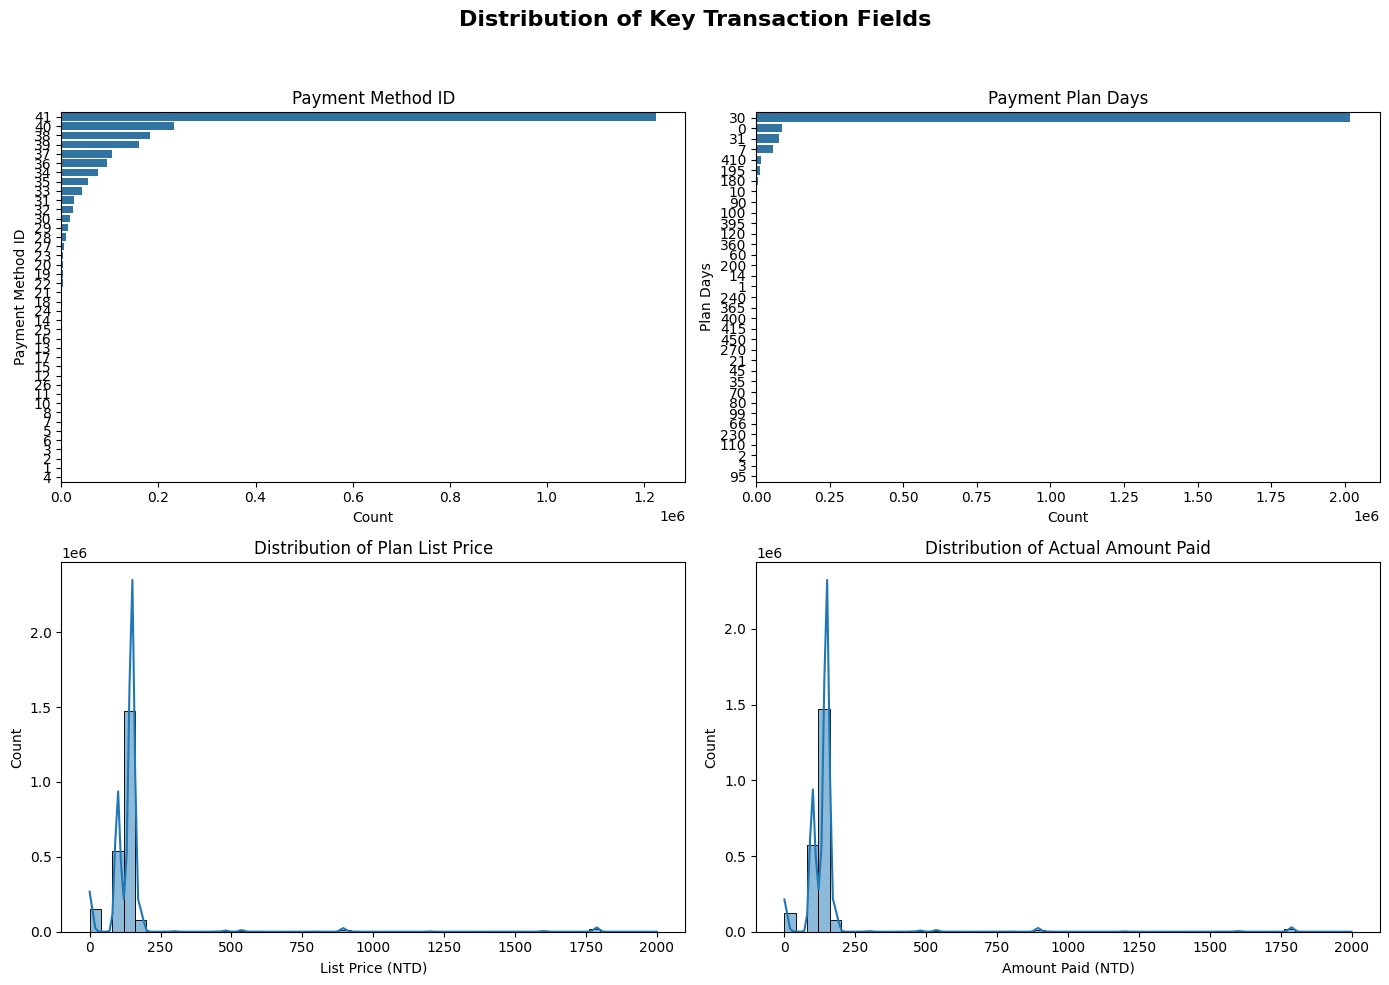

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Convert to Pandas (sampling down if data is huge)
pdf = df_bronze.select(
    "payment_method_id", "payment_plan_days", "plan_list_price", "actual_amount_paid"
).sample(fraction=0.1, seed=42).toPandas()

# 2️⃣ Set up the figure
plt.figure(figsize=(14, 10))
plt.suptitle("Distribution of Key Transaction Fields", fontsize=16, fontweight="bold")

# 3️⃣ Plot each distribution
plt.subplot(2, 2, 1)
sns.countplot(y="payment_method_id", data=pdf, order=pdf["payment_method_id"].value_counts().index)
plt.title("Payment Method ID")
plt.xlabel("Count")
plt.ylabel("Payment Method ID")

plt.subplot(2, 2, 2)
sns.countplot(y="payment_plan_days", data=pdf, order=pdf["payment_plan_days"].value_counts().index)
plt.title("Payment Plan Days")
plt.xlabel("Count")
plt.ylabel("Plan Days")

plt.subplot(2, 2, 3)
sns.histplot(pdf["plan_list_price"], bins=50, kde=True)
plt.title("Distribution of Plan List Price")
plt.xlabel("List Price (NTD)")

plt.subplot(2, 2, 4)
sns.histplot(pdf["actual_amount_paid"], bins=50, kde=True)
plt.title("Distribution of Actual Amount Paid")
plt.xlabel("Amount Paid (NTD)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()